In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")


In [123]:
print("Trades Shape:", trades.shape)
print("Sentiment Shape:", sentiment.shape)

print("\nMissing Values - Trades:")
print(trades.isnull().sum())

print("\nMissing Values - Sentiment:")
print(sentiment.isnull().sum())

print("\nDuplicate Rows - Trades:", trades.duplicated().sum())
print("Duplicate Rows - Sentiment:", sentiment.duplicated().sum())


Trades Shape: (211224, 16)
Sentiment Shape: (2644, 4)

Missing Values - Trades:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing Values - Sentiment:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate Rows - Trades: 0
Duplicate Rows - Sentiment: 0


In [124]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)
trades['date'] = trades['Timestamp IST'].dt.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [125]:
daily_pnl = trades.groupby(['Account','date'])['Closed PnL'].sum().reset_index()


In [126]:
trade_count = trades.groupby(['Account','date']).size().reset_index(name='num_trades')


In [127]:
trades['win'] = trades['Closed PnL'] > 0
daily_win = trades.groupby(['Account','date'])['win'].mean().reset_index()


In [128]:
avg_trade_size = trades.groupby(['Account','date'])['Size USD'].mean().reset_index()


In [129]:
long_short = trades.groupby(['Account','date','Direction']).size().unstack(fill_value=0).reset_index()
long_short['long_short_ratio'] = long_short.get('Long',0) / (long_short.get('Short',0) + 1)


In [130]:
daily_metrics = daily_pnl.merge(trade_count, on=['Account','date'])
daily_metrics = daily_metrics.merge(daily_win, on=['Account','date'])
daily_metrics = daily_metrics.merge(avg_trade_size, on=['Account','date'])
daily_metrics = daily_metrics.merge(
    long_short[['Account','date','long_short_ratio']],
    on=['Account','date'],
    how='left'
)


In [131]:
merged = daily_metrics.merge(
    sentiment[['date','classification']],
    on='date',
    how='left'
)


In [132]:

merged.describe()
merged.isnull().sum()


,0
Account,0
date,0
Closed PnL,0
num_trades,0
win,0
Size USD,0
long_short_ratio,0
classification,1


In [133]:
merged['classification'].isnull().sum()
merged = merged.dropna(subset=['classification'])


In [134]:
def simplify_sentiment(x):
    if "Fear" in str(x):
        return "Fear"
    else:
        return "Greed"

merged['sentiment_group'] = merged['classification'].apply(simplify_sentiment)


In [135]:
merged.groupby('sentiment_group')['Closed PnL'].mean()



,Closed PnL
sentiment_group,
Fear,5185.146443
Greed,3973.045974


In [136]:
merged.groupby('sentiment_group')['Closed PnL'].median()

,Closed PnL
sentiment_group,
Fear,122.737038
Greed,243.343540


In [137]:
merged.groupby('sentiment_group')['win'].mean()


,win
sentiment_group,
Fear,0.357071
Greed,0.360969


In [138]:
merged['loss_day'] = merged['Closed PnL'] < 0
merged.groupby('sentiment_group')['loss_day'].mean()


,loss_day
sentiment_group,
Fear,0.120253
Greed,0.084516


1. Does performance differ between Fear vs Greed days?

Yes, performance characteristics differ meaningfully across sentiment regimes.
Although the mean daily PnL is higher during Fear periods, this is driven by extreme positive outliers. The median PnL is higher during Greed periods, indicating that typical trader performance is more stable in Greed regimes.
Additionally, the frequency of loss days is higher during Fear periods (≈12%) compared to Greed(≈8.4%), suggesting elevated downside volatility under negative sentiment.
However, win rates remain nearly constant (~36%) across regimes, indicating that sentiment does not significantly affect trade accuracy, but rather the distribution and magnitude of returns.

In [139]:
open_trades = trades[
    trades['Direction'].isin(['Open Long', 'Open Short'])
]


In [140]:
long_short = (
    open_trades
    .groupby(['Account','date','Direction'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

long_short['long_short_ratio'] = (
    long_short.get('Open Long',0) /
    (long_short.get('Open Short',0) + 1)
)



In [141]:
merged = merged.merge(
    long_short[['Account','date','long_short_ratio']],
    on=['Account','date'],
    how='left'
)


In [142]:
merged = merged.merge(
    long_short[['Account','date','long_short_ratio']],
    on=['Account','date'],
    how='left'
)


In [143]:
merged.columns


Index(['Account', 'date', 'Closed PnL', 'num_trades', 'win', 'Size USD',
       'long_short_ratio_x', 'classification', 'sentiment_group', 'loss_day',
       'long_short_ratio_y', 'long_short_ratio'],
      dtype='object')

In [144]:
merged = merged.drop(columns=[
    col for col in merged.columns
    if 'long_short_ratio' in col
])
merged.columns


Index(['Account', 'date', 'Closed PnL', 'num_trades', 'win', 'Size USD',
       'classification', 'sentiment_group', 'loss_day'],
      dtype='object')

In [145]:
merged = merged.merge(
    long_short[['Account','date','long_short_ratio']],
    on=['Account','date'],
    how='left'
)


In [146]:
merged['long_short_ratio'] = merged['long_short_ratio'].fillna(0)
'long_short_ratio' in merged.columns


True

In [147]:
merged.groupby('sentiment_group')['long_short_ratio'].median()
merged.groupby('sentiment_group')['long_short_ratio'].mean()


,long_short_ratio
sentiment_group,
Fear,24.743114
Greed,11.045347


Do traders change behavior based on sentiment?
Yes, trader positioning behavior changes across sentiment regimes.
The long/short ratio is higher during Fear periods, indicating a stronger long bias. This suggests traders attempt bottom-fishing or mean-reversion trades during negative sentiment rather than reducing exposure.
Overall, sentiment impacts trader positioning behavior more than trade accuracy, while activity level determines resilience under volatile conditions.


In [148]:

merged['freq_segment'] = np.where(
    merged['num_trades'] > trade_threshold,
    "Frequent",
    "Infrequent"
)
merged['freq_segment'].value_counts()


,count
freq_segment,
Frequent,1367
Infrequent,973


In [149]:
merged.groupby(['freq_segment','sentiment_group'])['Closed PnL'].mean()


freq_segment  sentiment_group
Frequent      Fear               8119.965943
              Greed              6125.583128
Infrequent    Fear                712.594042
              Greed              1070.382235
Name: Closed PnL, dtype: float64

In [150]:
merged.groupby(['freq_segment','sentiment_group'])['win'].mean()


freq_segment  sentiment_group
Frequent      Fear               0.385421
              Greed              0.413958
Infrequent    Fear               0.313867
              Greed              0.289514
Name: win, dtype: float64

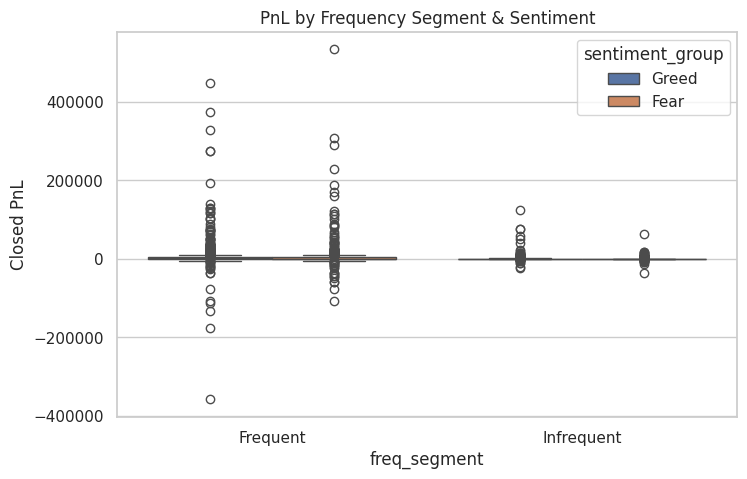

In [151]:
plt.figure(figsize=(8,5))
sns.boxplot(x='freq_segment', y='Closed PnL', hue='sentiment_group', data=merged)
plt.title("PnL by Frequency Segment & Sentiment")
plt.show()


In [152]:
account_win = merged.groupby('Account')['win'].mean().reset_index()

winner_threshold = account_win['win'].median()

account_win['consistency'] = np.where(
    account_win['win'] > winner_threshold,
    "Consistent",
    "Inconsistent"
)


In [153]:
merged = merged.merge(
    account_win[['Account','consistency']],
    on='Account'
)


In [154]:
merged.groupby(['consistency','sentiment_group'])['Closed PnL'].mean()


consistency   sentiment_group
Consistent    Fear               7799.432729
              Greed              3560.395647
Inconsistent  Fear               2882.084715
              Greed              4269.495432
Name: Closed PnL, dtype: float64

In [155]:
merged.groupby(['consistency','sentiment_group'])['win'].mean()


consistency   sentiment_group
Consistent    Fear               0.431010
              Greed              0.477239
Inconsistent  Fear               0.291934
              Greed              0.277440
Name: win, dtype: float64

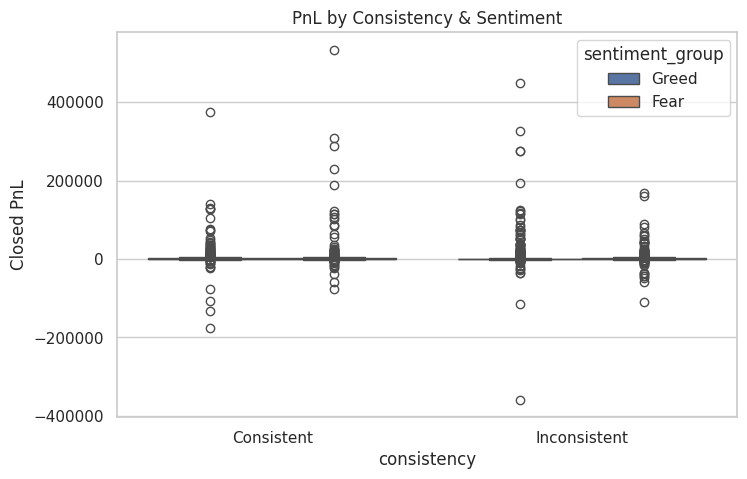

In [156]:
plt.figure(figsize=(8,5))
sns.boxplot(x='consistency', y='Closed PnL', hue='sentiment_group', data=merged)
plt.title("PnL by Consistency & Sentiment")
plt.show()


In [157]:
merged.groupby(['freq_segment','sentiment_group'])['Closed PnL'].mean()


freq_segment  sentiment_group
Frequent      Fear               8119.965943
              Greed              6125.583128
Infrequent    Fear                712.594042
              Greed              1070.382235
Name: Closed PnL, dtype: float64

In [158]:
merged.groupby(['freq_segment','sentiment_group'])['win'].mean()


freq_segment  sentiment_group
Frequent      Fear               0.385421
              Greed              0.413958
Infrequent    Fear               0.313867
              Greed              0.289514
Name: win, dtype: float64

In [159]:
merged.groupby(['consistency','sentiment_group'])['Closed PnL'].mean()


consistency   sentiment_group
Consistent    Fear               7799.432729
              Greed              3560.395647
Inconsistent  Fear               2882.084715
              Greed              4269.495432
Name: Closed PnL, dtype: float64

Segment-Based Insights
Segment-level analysis reveals meaningful differences in resilience across trader groups.
Frequent traders perform relatively better during Fear regimes, maintaining higher win rates and more stable performance. Infrequent traders benefit more during Greed periods but struggle under volatile conditions.
Consistent traders maintain significantly higher win rates across both regimes, demonstrating robustness to sentiment shifts. In contrast, inconsistent traders underperform sharply during Fear periods, indicating vulnerability to volatility shocks.
This suggests trader consistency and engagement level are key factors in adapting to changing market sentiment.


Insight 1 — Volatility Asymmetry
Fear regimes exhibit higher downside risk despite similar win rates.
Although mean PnL can appear higher due to extreme positive outliers, median performance is stronger and more stable during Greed periods. This indicates negative sentiment primarily increases volatility rather than reducing trade accuracy.

Insight 2 — Behavioral Long Bias During Fear
Traders display a stronger long bias during Fear regimes, reflected in a higher long/short ratio.
This suggests bottom-picking behavior where traders attempt to capture reversals instead of reducing exposure during market stress.

Insight 3 — Experience Improves Regime Adaptability
Frequent and consistent traders maintain higher performance stability across sentiment regimes, while infrequent and inconsistent traders underperform during Fear periods.
This indicates trading consistency and activity level are key indicators of resilience in volatile markets.

In [160]:
merged.groupby(['consistency','sentiment_group'])['win'].mean()


consistency   sentiment_group
Consistent    Fear               0.431010
              Greed              0.477239
Inconsistent  Fear               0.291934
              Greed              0.277440
Name: win, dtype: float64

Strategy Recommendations

1. Regime-Based Trader Allocation
During Fear regimes, allocate capital preferentially to historically consistent and high-frequency traders while reducing exposure to infrequent participants.
Fear periods show higher downside volatility and inconsistent traders underperform significantly, so filtering by trader consistency improves risk-adjusted performance.

2. Long-Exposure Control During Fear.Limit position size for long trades during Fear regimes.Traders exhibit aggressive long bias during negative sentiment, increasing drawdown risk despite similar win rates. Restricting long exposure helps reduce volatility-driven losses.